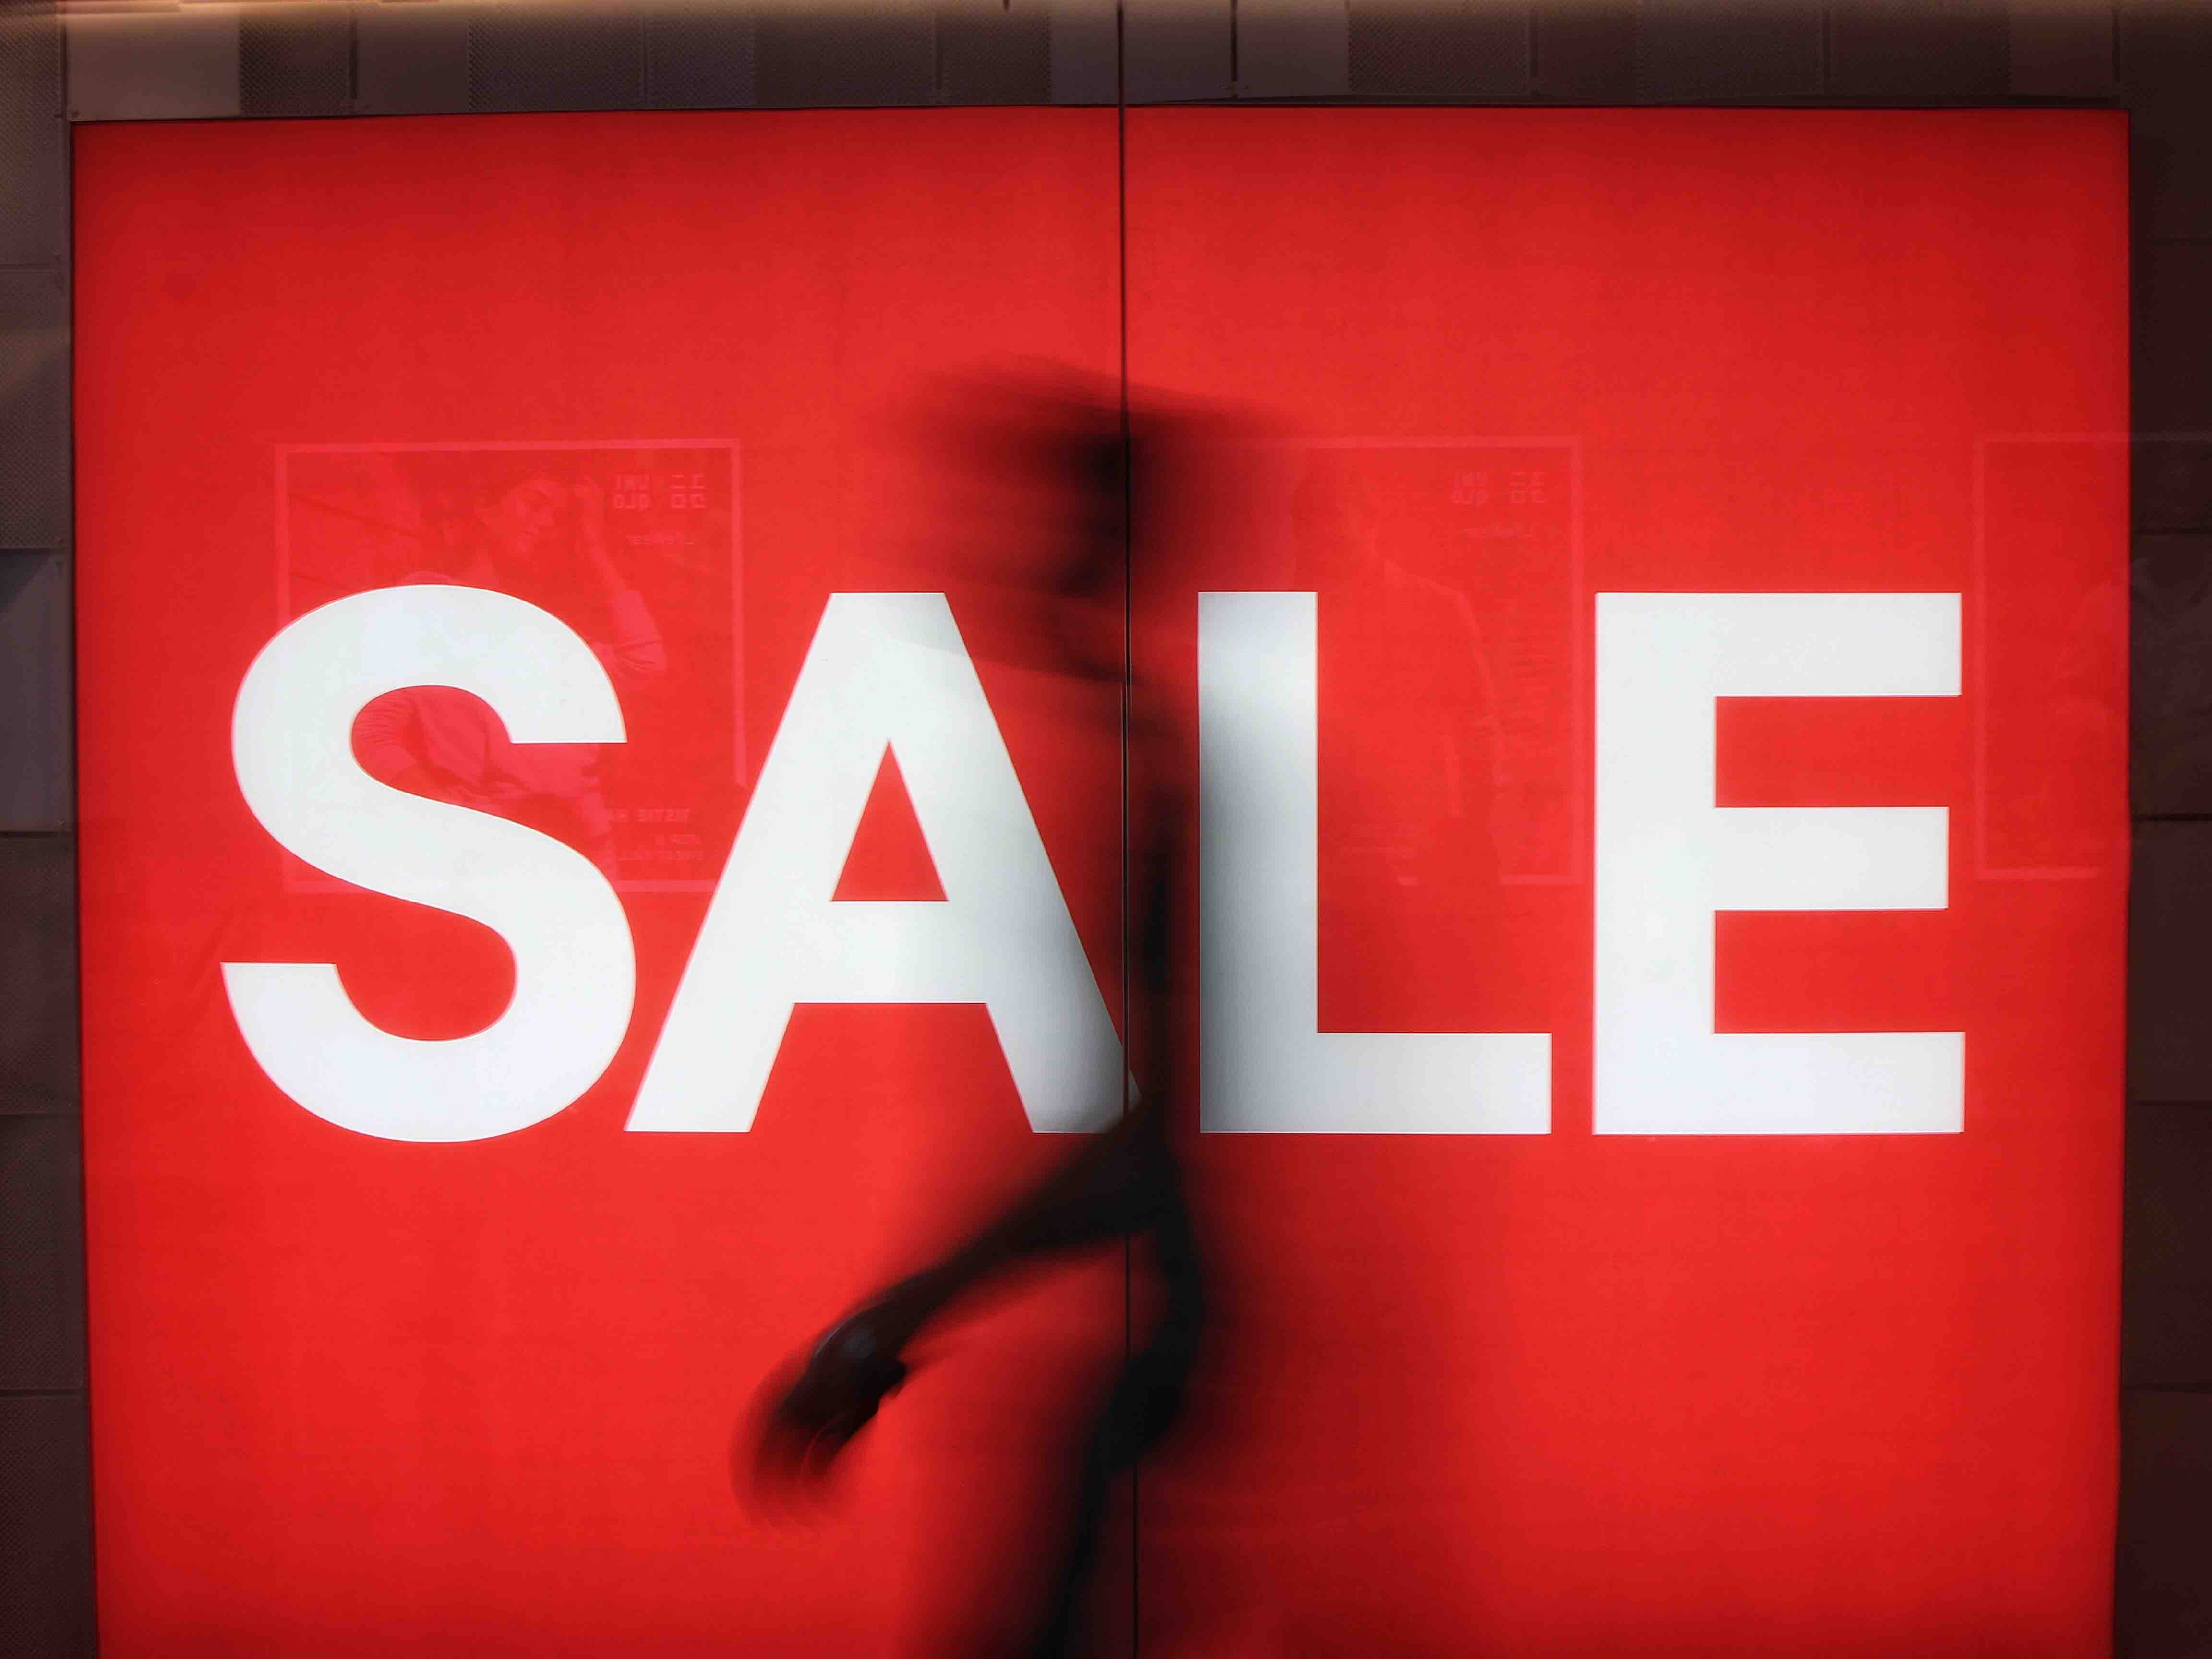
Photo by <a href="https://unsplash.com/@justinlim?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Justin Lim</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
<br />

I'm taking How to Win a Data Science Competition: Learn from Top Kagglers course. It was very wonderful and this is that course's final project.

# Flow
1. Most important ingenuity
2. Result
3. Requirements.txt
4. Feature Preprocessing
5. Mean Encording
6. EDA
7. Data Leakgages & Metrics Optimization
8. Generate Dataset
9. Validation
10. Adjust Dataset
11. Ensembles

<br />

## 1. Most important ingenuity
The features which I found and I think are very important are three.

Firstly, I will show the most important ingenuity of my model. It is aligning the train and validation average to the estimated 34 months' mean.

I think important data is sales_train.csv because these data become both input and target value.

First, I check the relationship to test.csv which we should predict and submit has a lot of columns that don't have any past months' sales information from sales_train.csv: approximately 45%. From that, the information of other data such as items, shops, and especially item_categories information (after I add categories transition data, model greatly improved than other data).

Next, I found the amount of sales is decreasing from the first month to last month. The below graph shows the mean item count per month for each month 0~33.

The mean is decreasing, so I want to eliminate the descent because I generate a data set of the transition of each month's sales information to predict the next month. For example, I add 6 months of sales data of the same shop, the same item, the same shop, the same item, and the same category. Thus, this previous information is very important, because the training target may become one years ago data.

Thus, I used LinearRegression from scikit-learn, and I adjusted the data by this program.

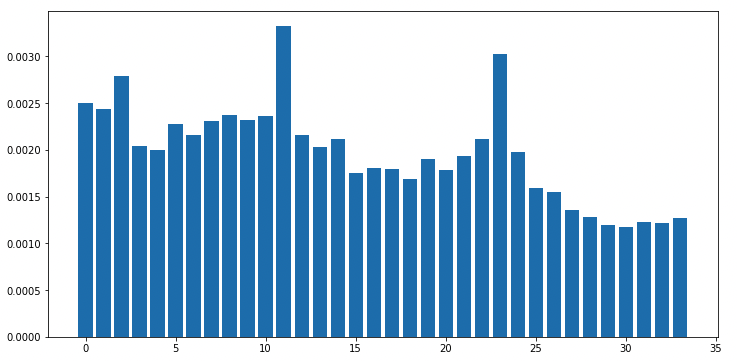

```python
month_means = features[i].loc[:, 0:].mean()
plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns,month_means)

x = np.array(features[i].loc[:, 0:].columns)
x = x.reshape(-1, 1)
y = np.array(month_means)
y = y.reshape(-1, 1)

# Regression to predict 34 month amm (around month mean)
mm_reg_model = LinearRegression()
mm_reg_model.fit(x,y)

plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns,month_means)

x = np.concatenate([x, [[34]]], axis=0)
y = mm_reg_model.predict(x)
plt.plot(x, y, linewidth=4, color="red", marker="o")

mm_ratio = np.array(y / y[34])
mm_ratio = mm_ratio[:34]
mm_ratio = mm_ratio.reshape(len(mm_ratio))

plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns, month_means / mm_ratio)

features[i].loc[:, 0:] = features[i].loc[:, 0:] / mm_ratio
```

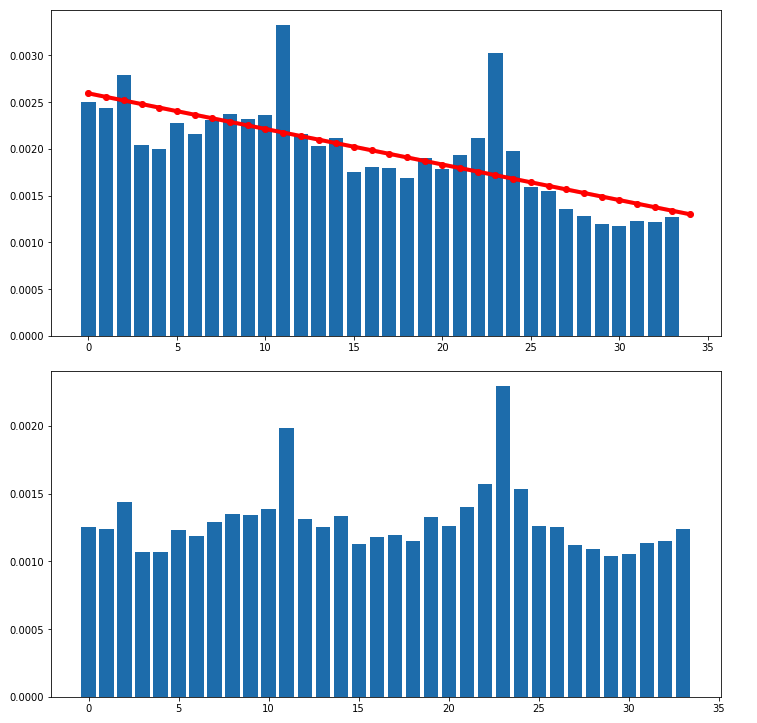

I set 34 months mean prediction which was predicted by linear regression as 1 and aligned columns for each month.

However, a model trained by using that data becomes worse. I think that reason is this information on those changes is important, so I took other approaches.

That approach is estimating 34 months' mean.

After taking the lessons, Metrics optimization, I submit single values predictions many times, to estimate 34 months' correct mean, because I know they used RMSE, so the value which can get the best score is close to the mean of target data. The below list is result.

### **Single value scores**

- 0.2     : 1.220329 and 1.206208.
- 0.25   : 1.217912 and 1.203698.
- 0.3     : 1.217545 and 1.203262.
- 0.35   : 1.219230 and 1.204903.
- 0.4     : 1.222959 and 1.208611.
- 0.5     : 1.23646
- 0.6     : 1.245039 and 1.235736.

The above data is the result, from that I can estimate the mean close to 0.3. Thus, I adjust the train and validation data to close to 0.3.

```python
adj_x_train = np.array(x_train)
adj_y_train = np.array(y_train)
adj_y_train = adj_y_train.clip(0, 20.0 / transition_max)
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_train))
# One time delete 0.01%
over_index = np.where(adj_y_train < std_pre_ave)[0]
print(over_index)
print(len(adj_y_train), len(over_index))
drop_rate = 0.035
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005
%%time
for i in range(100):
    over_index = np.where(adj_y_train < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_train = np.delete(adj_x_train, drop_index, 0)
    adj_y_train = np.delete(adj_y_train, drop_index)
    if adj_y_train.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())
```


# 2. Result
This process of eliminating some columns to close an accurate dataset was good I think.

Version 2 is non adjusted and LB score 1.00716
Version 3 is adjusted but LB socre becomes worse 1.00718

Version 4 is adjusted more and LB score is 1.00637.

It improved very little, so it may be meaningless.

# 3. Requirements.txt
MyApp
sklearn: 0.23.2
LightGBM: 3.2.1
CatBoost: 1.0.0

In [1]:
!pip freeze > requirements.txt.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


from tqdm import tqdm
from itertools import product
from sklearn.model_selection import train_test_split
import seaborn as sns

import sys
import os
import gc
from glob import glob
import pickle
import json
import subprocess
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, RepeatedStratifiedKFold


In [3]:
DF_CEILING_VALUE = 20000.0
SHOP_CEILING_VALUE = 999999.9
ITEM_CEILING_VALUE = 999999.9

In [4]:
PATH = '../input/competitive-data-science-predict-future-sales/'

df = pd.read_csv(PATH + 'sales_train.csv')
df_test = pd.read_csv(PATH + 'test.csv')
sample = pd.read_csv(PATH + 'sample_submission.csv')
items = pd.read_csv(PATH + 'items.csv')
shops = pd.read_csv(PATH + 'shops.csv')
item_cats = pd.read_csv(PATH + 'item_categories.csv')

In [5]:
data_files_names = ["df","df_test","sample","items","shops","item_cats"]
data_files = [df,df_test,sample,items,shops,item_cats]

# 4. Feature Preprocessing

In [6]:
df_test = df_test.drop('ID', axis=1)

In [7]:
df

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[2935849 rows x 6 columns]

In [8]:
df.loc[df['item_cnt_day'] < 0.0, 'item_cnt_day'] = 0.0

In [9]:
df[df['item_cnt_day'] > 100.0]

date  date_block_num  shop_id  item_id   item_price  \
566159   11.06.2013               5       12     2808   999.000000   
620237   14.06.2013               5       42    16787  2559.746729   
836296   29.08.2013               7       12     2808   999.000000   
845690   18.09.2013               8       42     3732  2521.211982   
845703   18.09.2013               8       42     3734  2520.730769   
...             ...             ...      ...      ...          ...   
2864262  28.09.2015              32       12     9248  1500.000000   
2864264  30.09.2015              32       12     9244  1296.273292   
2909401  14.10.2015              33       12    20949     4.000000   
2909818  28.10.2015              33       12    11373     0.908714   
2918705  02.10.2015              33        9     4201   399.000000   

         item_cnt_day  
566159          200.0  
620237          107.0  
836296          150.0  
845690          217.0  
845703          104.0  
...               ...  
2864262         139.0  
2864264         161.0  
2909401         500.0  
2909818        2169.0  
2918705         110.0  

[138 rows x 6 columns]

In [10]:
df.loc[df['item_cnt_day'] > 100.0, 'item_cnt_day'] = 1.0
len(df[df['item_cnt_day']>10.0])

9978

In [11]:
df[df['item_cnt_day'] > 10.0]

date  date_block_num  shop_id  item_id   item_price  \
352      15.01.2013               0       25     2973  2499.000000   
404      25.01.2013               0       25     2972   599.000000   
5410     02.01.2013               0       25    16450   399.000000   
8547     30.01.2013               0       22     6736   599.000000   
9348     30.01.2013               0       22     3186   299.500000   
...             ...             ...      ...      ...          ...   
2935377  13.10.2015              33       25    10202  1160.176471   
2935379  15.10.2015              33       25    10202  1163.000000   
2935757  21.10.2015              33       25     7224  4499.000000   
2935758  22.10.2015              33       25     7224  4454.000000   
2935766  07.10.2015              33       25     7223  3999.000000   

         item_cnt_day  
352              13.0  
404              13.0  
5410             11.0  
8547             30.0  
9348             22.0  
...               ...  
2935377          34.0  
2935379          15.0  
2935757          47.0  
2935758          15.0  
2935766          35.0  

[9978 rows x 6 columns]

In [12]:
df.loc[df['shop_id'] == 57, 'shop_id'] = 0
df.loc[df['shop_id'] == 58, 'shop_id'] = 1
df.loc[df['shop_id'] == 11, 'shop_id'] = 10
df.loc[df['shop_id'] == 40, 'shop_id'] = 39

df_test.loc[df_test['shop_id'] == 57, 'shop_id'] = 0
df_test.loc[df_test['shop_id'] == 58, 'shop_id'] = 1
df_test.loc[df_test['shop_id'] == 11, 'shop_id'] = 10
df_test.loc[df_test['shop_id'] == 40, 'shop_id'] = 39

In [13]:
df['shop_item_id'] = df['shop_id'].astype('str').str.zfill(2) +  df['item_id'].astype('str').str.zfill(5)
df['item_category_id'] = pd.merge(df, items, on='item_id',how='left')['item_category_id']
df

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day shop_item_id  item_category_id  
0                 1.0      5922154                37  
1                 1.0      2502552                58  
2                 0.0      2502552                58  
3                 1.0      2502554                58  
4                 1.0      2502555                56  
...               ...          ...               ...  
2935844           1.0      2507409                55  
2935845           1.0      2507460                55  
2935846           1.0      2507459                55  
2935847           1.0      2507440                57  
2935848           1.0      2507460                55  

[2935849 rows x 8 columns]

In [14]:
df = df.groupby(['date_block_num', 'shop_id','item_id','shop_item_id', 'item_category_id'], as_index=False
        ).agg({'item_cnt_day':'sum'}
        ).rename(columns={'item_cnt_day':'mon_shop_item_cnt'})
df

date_block_num  shop_id  item_id shop_item_id  item_category_id  \
0                     0        0       32      0000032                40   
1                     0        0       33      0000033                37   
2                     0        0       35      0000035                40   
3                     0        0       43      0000043                40   
4                     0        0       51      0000051                57   
...                 ...      ...      ...          ...               ...   
1608267              33       59    22087      5922087                83   
1608268              33       59    22088      5922088                83   
1608269              33       59    22091      5922091                83   
1608270              33       59    22100      5922100                42   
1608271              33       59    22102      5922102                42   

         mon_shop_item_cnt  
0                      6.0  
1                      3.0  
2                      1.0  
3                      1.0  
4                      2.0  
...                    ...  
1608267                6.0  
1608268                2.0  
1608269                1.0  
1608270                1.0  
1608271                1.0  

[1608272 rows x 6 columns]

In [15]:
# Add shop_item_id to df_test
df_test['shop_item_id'] = df_test['shop_id'].astype('str').str.zfill(2) + df_test['item_id'].astype('str').str.zfill(5)
df_test['item_category_id'] = pd.merge(df_test, items, on='item_id',how='left')['item_category_id']
df_test

shop_id  item_id shop_item_id  item_category_id
0             5     5037      0505037                19
1             5     5320      0505320                55
2             5     5233      0505233                19
3             5     5232      0505232                23
4             5     5268      0505268                20
...         ...      ...          ...               ...
214195       45    18454      4518454                55
214196       45    16188      4516188                64
214197       45    15757      4515757                55
214198       45    19648      4519648                40
214199       45      969      4500969                37

[214200 rows x 4 columns]

In [16]:
count = 0
df_ids = df['shop_item_id'].unique()
repeat_count = 0
for one_id in df_test['shop_item_id'].sample(1000):
    if one_id in df_ids:
        count += 1
    repeat_count += 1

    if repeat_count > 1000:
        break
print(count / repeat_count)

0.523


(array([1.607663e+06, 4.090000e+02, 8.800000e+01, 4.500000e+01,
        3.400000e+01, 1.700000e+01, 9.000000e+00, 4.000000e+00,
        2.000000e+00, 1.000000e+00]),
 array([   0. ,  130.5,  261. ,  391.5,  522. ,  652.5,  783. ,  913.5,
        1044. , 1174.5, 1305. ]),
 <BarContainer object of 10 artists>)

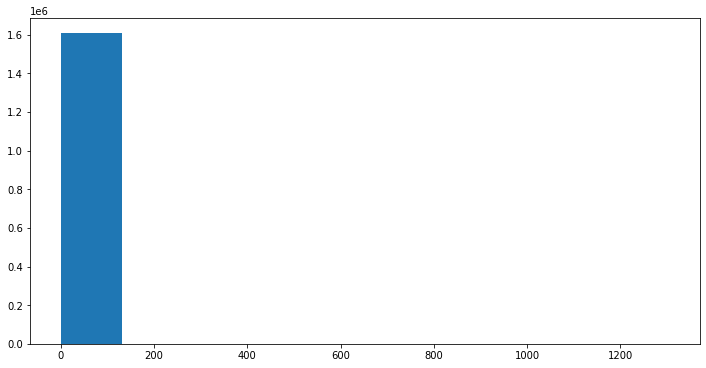

In [17]:
plt.figure(figsize=(12,6))
plt.hist(df['mon_shop_item_cnt'])

In [18]:
df.loc[df['mon_shop_item_cnt'] > 100.0, 'mon_shop_item_cnt'] = 101.0

In [19]:
print(len(df.loc[df['mon_shop_item_cnt'] > 100.0]), len(df.loc[df['mon_shop_item_cnt'] > 101.0]))

976 0


In [20]:
len(np.unique(np.concatenate([df['shop_item_id'], df_test['shop_item_id']])))

520915

In [21]:
# Outer -> 520915
transition = pd.DataFrame(np.unique(np.concatenate([df['shop_item_id'], df_test['shop_item_id']])), columns=['shop_item_id'])
for i in range(34):
    transition = pd.merge(transition, df[df['date_block_num']==i].drop(['date_block_num', 'shop_id', 'item_id', 'item_category_id'], axis=1).rename(columns={'mon_shop_item_cnt': i}), on='shop_item_id', how='left')
transition = transition.fillna(0)
transition

shop_item_id    0     1     2    3    4    5    6    7    8  ...   24  \
0           0000030  0.0  31.0  24.0  3.0  1.0  0.0  1.0  1.0  1.0  ...  2.0   
1           0000031  0.0  11.0  10.0  1.0  1.0  0.0  0.0  0.0  0.0  ...  2.0   
2           0000032  6.0  10.0  12.0  6.0  2.0  4.0  3.0  7.0  5.0  ...  0.0   
3           0000033  3.0   3.0   0.0  0.0  2.0  3.0  1.0  2.0  2.0  ...  2.0   
4           0000034  0.0   0.0   0.0  2.0  0.0  2.0  1.0  1.0  0.0  ...  0.0   
...             ...  ...   ...   ...  ...  ...  ...  ...  ...  ...  ...  ...   
520910      5922162  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
520911      5922163  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
520912      5922164  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
520913      5922166  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
520914      5922167  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

         25   26   27   28   29   30   31   32   33  
0       1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
2       1.0  1.0  1.0  0.0  0.0  2.0  2.0  0.0  1.0  
3       1.0  2.0  1.0  0.0  0.0  0.0  0.0  3.0  2.0  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  
520910  9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  
520911  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
520912  2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
520913  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
520914  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[520915 rows x 35 columns]

<BarContainer object of 34 artists>

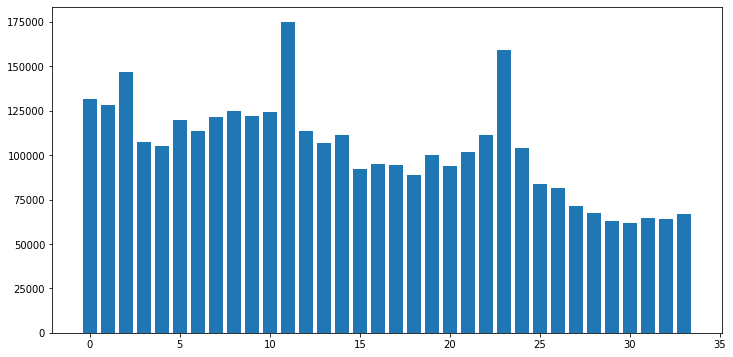

In [22]:
plt.figure(figsize=(12,6))
plt.bar(transition.loc[:, 0:].columns,transition.loc[:, 0:].sum())

(array([5.20566e+05, 2.74000e+02, 1.60000e+01, 1.20000e+01, 7.00000e+00,
        3.00000e+00, 8.00000e+00, 9.00000e+00, 9.00000e+00, 1.10000e+01]),
 array([   0. ,  295.7,  591.4,  887.1, 1182.8, 1478.5, 1774.2, 2069.9,
        2365.6, 2661.3, 2957. ]),
 <BarContainer object of 10 artists>)

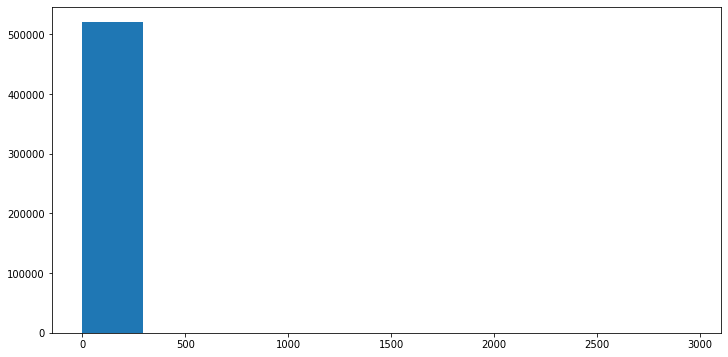

In [23]:
plt.figure(figsize=(12,6))
plt.hist(transition.loc[:, 0:].T.sum())

In [24]:
# I think these data is too big but not invalid
transition[transition.loc[:, 0:].T.sum() >= 500.0]

shop_item_id    0    1    2     3      4      5      6      7      8  \
2238        0004178  0.0  0.0  0.0   0.0    0.0    0.0    0.0   10.0   27.0   
2637        0004870  0.0  0.0  0.0   0.0    0.0    0.0    7.0   13.0   27.0   
13770       0020949  0.0  0.0  0.0   0.0    6.0  101.0  101.0    2.0   50.0   
16572       0104870  0.0  0.0  0.0   0.0    0.0    0.0    4.0    8.0   19.0   
25320       0120949  0.0  0.0  0.0   0.0    0.0  101.0  101.0    1.0   10.0   
...             ...  ...  ...  ...   ...    ...    ...    ...    ...    ...   
495640      5513098  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0   
495641      5513099  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0   
495807      5513342  0.0  0.0  0.0   0.0    0.0    0.0    0.0    0.0    0.0   
510349      5620949  0.0  0.0  0.0   4.0   24.0  101.0  101.0  101.0   92.0   
520417      5920949  0.0  0.0  0.0  25.0  101.0  101.0  101.0   94.0  101.0   

        ...     24     25    26    27    28     29    30     31    32     33  
2238    ...   30.0   24.0  26.0  20.0  10.0   11.0   7.0   14.0  19.0   10.0  
2637    ...   24.0   14.0  11.0   9.0   7.0    7.0   6.0    9.0  12.0    6.0  
13770   ...  101.0  101.0   0.0  25.0  90.0   98.0  94.0  101.0  88.0  101.0  
16572   ...   45.0   20.0  10.0  12.0   8.0    5.0   8.0   14.0  15.0   12.0  
25320   ...  101.0  101.0  38.0   0.0  10.0   37.0  14.0   47.0  40.0   67.0  
...     ...    ...    ...   ...   ...   ...    ...   ...    ...   ...    ...  
495640  ...   60.0   73.0  46.0  32.0  58.0   44.0  38.0   44.0  55.0   47.0  
495641  ...  101.0   82.0  87.0  59.0  71.0   61.0  48.0   59.0  64.0   62.0  
495807  ...   26.0   28.0  32.0  27.0  17.0   34.0  29.0   23.0  29.0   28.0  
510349  ...  101.0   60.0  36.0  71.0  80.0  101.0  74.0   94.0  59.0   89.0  
520417  ...   49.0   76.0  68.0  48.0  32.0   35.0  23.0   33.0  18.0   19.0  

[110 rows x 35 columns]

In [25]:
# transition_mean = transition.loc[:, 0:].mean().mean()
# transition_std = transition.loc[:, 0:].std().std()
transition_max = transition.loc[:, 0:].max().max()
transition_max

101.0

In [26]:
std_transition = transition.copy()
std_transition.loc[:, 0:] = (std_transition.loc[:, 0:]) / transition_max
std_transition

shop_item_id         0         1         2         3         4  \
0           0000030  0.000000  0.306931  0.237624  0.029703  0.009901   
1           0000031  0.000000  0.108911  0.099010  0.009901  0.009901   
2           0000032  0.059406  0.099010  0.118812  0.059406  0.019802   
3           0000033  0.029703  0.029703  0.000000  0.000000  0.019802   
4           0000034  0.000000  0.000000  0.000000  0.019802  0.000000   
...             ...       ...       ...       ...       ...       ...   
520910      5922162  0.000000  0.000000  0.000000  0.000000  0.000000   
520911      5922163  0.000000  0.000000  0.000000  0.000000  0.000000   
520912      5922164  0.000000  0.000000  0.000000  0.000000  0.000000   
520913      5922166  0.000000  0.000000  0.000000  0.000000  0.000000   
520914      5922167  0.000000  0.000000  0.000000  0.000000  0.000000   

               5         6         7         8  ...        24        25  \
0       0.000000  0.009901  0.009901  0.009901  ...  0.019802  0.009901   
1       0.000000  0.000000  0.000000  0.000000  ...  0.019802  0.000000   
2       0.039604  0.029703  0.069307  0.049505  ...  0.000000  0.009901   
3       0.029703  0.009901  0.019802  0.019802  ...  0.019802  0.009901   
4       0.019802  0.009901  0.009901  0.000000  ...  0.000000  0.000000   
...          ...       ...       ...       ...  ...       ...       ...   
520910  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.089109   
520911  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
520912  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.019802   
520913  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
520914  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

              26        27        28        29        30        31        32  \
0       0.000000  0.009901  0.000000  0.009901  0.000000  0.009901  0.000000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.009901  0.000000   
2       0.009901  0.009901  0.000000  0.000000  0.019802  0.019802  0.000000   
3       0.019802  0.009901  0.000000  0.000000  0.000000  0.000000  0.029703   
4       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
520910  0.039604  0.009901  0.009901  0.000000  0.000000  0.009901  0.000000   
520911  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
520912  0.009901  0.019802  0.000000  0.000000  0.009901  0.000000  0.000000   
520913  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
520914  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              33  
0       0.000000  
1       0.009901  
2       0.009901  
3       0.019802  
4       0.000000  
...          ...  
520910  0.000000  
520911  0.000000  
520912  0.000000  
520913  0.000000  
520914  0.000000  

[520915 rows x 35 columns]

In [27]:
shops.loc[shops['shop_id'] == 57, 'shop_id'] = 0
shops.loc[shops['shop_id'] == 58, 'shop_id'] = 1
shops.loc[shops['shop_id'] == 11, 'shop_id'] = 10
shops.loc[shops['shop_id'] == 40, 'shop_id'] = 39
shops

shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       10
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                             Калуга ТРЦ "XXI век"       15
16                                 Коломна ТЦ "Рио"       16
17                    Красноярск ТЦ "Взлетка Плаза"       17
18                             Красноярск ТЦ "Июнь"       18
19                            Курск ТЦ "Пушкинский"       19
20                              Москва "Распродажа"       20
21                           Москва МТРЦ "Афи Молл"       21
22                               Москва Магазин С21       22
23                 Москва ТК "Буденовский" (пав.А2)       23
24                 Москва ТК "Буденовский" (пав.К7)       24
25                              Москва ТРК "Атриум"       25
26                      Москва ТЦ "Ареал" (Беляево)       26
27                   Москва ТЦ "МЕГА Белая Дача II"       27
28                  Москва ТЦ "МЕГА Теплый Стан" II       28
29               Москва ТЦ "Новый век" (Новокосино)       29
30                           Москва ТЦ "Перловский"       30
31                          Москва ТЦ "Семеновский"       31
32                       Москва ТЦ "Серебряный Дом"       32
33                                Мытищи ТРК "XL-3"       33
34                             Н.Новгород ТРЦ "РИО"       34
35                      Н.Новгород ТРЦ "Фантастика"       35
36            Новосибирск ТРЦ "Галерея Новосибирск"       36
37                            Новосибирск ТЦ "Мега"       37
38                                   Омск ТЦ "Мега"       38
39            РостовНаДону ТРК "Мегацентр Горизонт"       39
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       39
41                           РостовНаДону ТЦ "Мега"       41
42                           СПб ТК "Невский Центр"       42
43                                  СПб ТК "Сенная"       43
44                              Самара ТЦ "Мелодия"       44
45                             Самара ТЦ "ПаркХаус"       45
46                            Сергиев Посад ТЦ "7Я"       46
47                           Сургут ТРЦ "Сити Молл"       47
48                     Томск ТРЦ "Изумрудный Город"       48
49                            Тюмень ТРЦ "Кристалл"       49
50                               Тюмень ТЦ "Гудвин"       50
51                        Тюмень ТЦ "Зеленый Берег"       51
52                             Уфа ТК "Центральный"       52
53                                 Уфа ТЦ "Семья" 2       53
54                                  Химки ТЦ "Мега"       54
55                         Цифровой склад 1С-Онлайн       55
56                             Чехов ТРЦ "Карнавал"       56
57                          Якутск Орджоникидзе, 56        0
58                          Якутск ТЦ "Центральный"        1
59                           Ярославль ТЦ "Альтаир"       59

In [28]:
shop_df = df.groupby(['date_block_num', 'shop_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'}
        )
shop_transition = pd.DataFrame(shops['shop_id'].unique(), columns=['shop_id'])

for i in range(34):
    shop_transition = pd.merge(shop_transition, shop_df[shop_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='shop_id', how='left')
shop_transition = shop_transition.fillna(0)

shop_transition_max = shop_transition.loc[:, 0:].max().max()
shop_transition.loc[:, 0:] = (shop_transition.loc[:, 0:]) / shop_transition_max

shop_transition

shop_id         0         1         2         3         4         5  \
0         0  0.369306  0.405654  0.436706  0.364738  0.347259  0.383607   
1         1  0.195114  0.222722  0.250331  0.188096  0.153138  0.193326   
2         2  0.076205  0.032376  0.050053  0.038731  0.036613  0.055085   
3         3  0.050781  0.053032  0.063493  0.042903  0.047537  0.052238   
4         4  0.140162  0.134799  0.136984  0.019002  0.080244  0.096994   
5         5  0.000000  0.058197  0.089844  0.066737  0.073557  0.092360   
6         6  0.244902  0.265956  0.293366  0.210143  0.199947  0.244372   
7         7  0.165387  0.166578  0.163136  0.102026  0.109110  0.138308   
8         8  0.096862  0.076536  0.065082  0.000000  0.000000  0.000000   
9         9  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10       10  0.061904  0.067929  0.067333  0.050053  0.045220  0.050583   
11       12  0.058329  0.080906  0.094743  0.093154  0.061043  0.089910   
12       13  0.077993  0.068591  0.082428  0.067399  0.073093  0.089910   
13       14  0.117783  0.119108  0.125530  0.082826  0.097060  0.117982   
14       15  0.180747  0.182468  0.188030  0.143604  0.127979  0.160487   
15       16  0.197828  0.173530  0.204714  0.140559  0.147113  0.194783   
16       17  0.000000  0.000000  0.000000  0.000000  0.000000  0.059984   
17       18  0.189817  0.221398  0.232786  0.160553  0.185712  0.194518   
18       19  0.202132  0.188294  0.200742  0.151947  0.136785  0.172934   
19       20  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20       21  0.098980  0.122948  0.148173  0.122484  0.109044  0.125530   
21       22  0.127715  0.162275  0.171544  0.152542  0.110832  0.142015   
22       23  0.129039  0.128708  0.140691  0.112818  0.000000  0.000000   
23       24  0.117519  0.118247  0.133475  0.052503  0.130429  0.166843   
24       25  0.543631  0.526218  0.637315  0.520922  0.452595  0.506224   
25       26  0.154661  0.172537  0.201470  0.157971  0.142611  0.168763   
26       27  0.367916  0.301377  0.361096  0.261520  0.233249  0.018207   
27       28  0.463387  0.360765  0.458289  0.325344  0.350967  0.425583   
28       29  0.186970  0.188030  0.209481  0.149497  0.151682  0.179158   
29       30  0.197497  0.180416  0.200609  0.157839  0.152873  0.177172   
30       31  0.673795  0.737752  0.824285  0.629635  0.598649  0.609309   
31       32  0.082296  0.099510  0.125265  0.090704  0.080310  0.097590   
32       33  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
33       34  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
34       35  0.141088  0.145988  0.170485  0.122484  0.129436  0.145524   
35       36  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
36       37  0.159296  0.147180  0.174590  0.129767  0.134137  0.115863   
37       38  0.113678  0.111030  0.133210  0.091565  0.088652  0.102225   
38       39  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
39       41  0.132746  0.123146  0.120365  0.091962  0.103085  0.139367   
40       42  0.264764  0.262977  0.322895  0.263904  0.237818  0.256753   
41       43  0.117519  0.134997  0.166181  0.124868  0.107852  0.133673   
42       44  0.113811  0.121425  0.141883  0.107918  0.091565  0.110699   
43       45  0.108249  0.101496  0.124934  0.083024  0.088520  0.116724   
44       46  0.223186  0.176443  0.205575  0.143273  0.159693  0.179688   
45       47  0.140625  0.121226  0.131488  0.102423  0.112818  0.107256   
46       48  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
47       49  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
48       50  0.226033  0.202397  0.239208  0.181740  0.188030  0.239407   
49       51  0.180945  0.151218  0.172471  0.128774  0.148504  0.145657   
50       52  0.120432  0.115334  0.134733  0.095802  0.098451  0.120233   
51       53  0.137116  0.126920  0.156978  0.100437  0.115135  0.138837   
52       54  0.619372  0.5337

In [29]:
shop_feature = transition.loc[:, ['shop_item_id']].copy()
shop_feature['shop_id'] = shop_feature['shop_item_id'].str[:2].astype(int)
shop_feature

shop_item_id  shop_id
0           0000030        0
1           0000031        0
2           0000032        0
3           0000033        0
4           0000034        0
...             ...      ...
520910      5922162       59
520911      5922163       59
520912      5922164       59
520913      5922166       59
520914      5922167       59

[520915 rows x 2 columns]

In [30]:
shop_feature = pd.merge(shop_feature, shop_transition, on='shop_id', how='left')
shop_feature = shop_feature.drop('shop_id', axis=1)
shop_feature

shop_item_id         0         1         2         3         4  \
0           0000030  0.369306  0.405654  0.436706  0.364738  0.347259   
1           0000031  0.369306  0.405654  0.436706  0.364738  0.347259   
2           0000032  0.369306  0.405654  0.436706  0.364738  0.347259   
3           0000033  0.369306  0.405654  0.436706  0.364738  0.347259   
4           0000034  0.369306  0.405654  0.436706  0.364738  0.347259   
...             ...       ...       ...       ...       ...       ...   
520910      5922162  0.134137  0.126192  0.134534  0.092029  0.090241   
520911      5922163  0.134137  0.126192  0.134534  0.092029  0.090241   
520912      5922164  0.134137  0.126192  0.134534  0.092029  0.090241   
520913      5922166  0.134137  0.126192  0.134534  0.092029  0.090241   
520914      5922167  0.134137  0.126192  0.134534  0.092029  0.090241   

               5         6         7         8  ...        24        25  \
0       0.383607  0.375265  0.358845  0.345008  ...  0.267015  0.234176   
1       0.383607  0.375265  0.358845  0.345008  ...  0.267015  0.234176   
2       0.383607  0.375265  0.358845  0.345008  ...  0.267015  0.234176   
3       0.383607  0.375265  0.358845  0.345008  ...  0.267015  0.234176   
4       0.383607  0.375265  0.358845  0.345008  ...  0.267015  0.234176   
...          ...       ...       ...       ...  ...       ...       ...   
520910  0.111891  0.115135  0.135990  0.131819  ...  0.085871  0.080045   
520911  0.111891  0.115135  0.135990  0.131819  ...  0.085871  0.080045   
520912  0.111891  0.115135  0.135990  0.131819  ...  0.085871  0.080045   
520913  0.111891  0.115135  0.135990  0.131819  ...  0.085871  0.080045   
520914  0.111891  0.115135  0.135990  0.131819  ...  0.085871  0.080045   

              26        27        28        29        30        31        32  \
0       0.207296  0.188692  0.159958  0.162010  0.156051  0.183991  0.150291   
1       0.207296  0.188692  0.159958  0.162010  0.156051  0.183991  0.150291   
2       0.207296  0.188692  0.159958  0.162010  0.156051  0.183991  0.150291   
3       0.207296  0.188692  0.159958  0.162010  0.156051  0.183991  0.150291   
4       0.207296  0.188692  0.159958  0.162010  0.156051  0.183991  0.150291   
...          ...       ...       ...       ...       ...       ...       ...   
520910  0.079714  0.068591  0.060779  0.060448  0.066075  0.080442  0.060580   
520911  0.079714  0.068591  0.060779  0.060448  0.066075  0.080442  0.060580   
520912  0.079714  0.068591  0.060779  0.060448  0.066075  0.080442  0.060580   
520913  0.079714  0.068591  0.060779  0.060448  0.066075  0.080442  0.060580   
520914  0.079714  0.068591  0.060779  0.060448  0.066075  0.080442  0.060580   

              33  
0       0.152873  
1       0.152873  
2       0.152873  
3       0.152873  
4       0.152873  
...          ...  
520910  0.052436  
520911  0.052436  
520912  0.052436  
520913  0.052436  
520914  0.052436  

[520915 rows x 35 columns]

In [31]:
items

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4                    40  
...                 ...  
22165                31  
22166                54  
22167                49  
22168                62  
22169                69  

[22170 rows x 3 columns]

In [32]:
item_df = df.groupby(['date_block_num', 'item_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'})
item_transition = pd.DataFrame(items['item_id'].unique(), columns=['item_id'])

for i in range(34):
    item_transition = pd.merge(item_transition, item_df[item_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='item_id', how='left')
item_transition = item_transition.fillna(0)

item_transition_max = item_transition.loc[:, 0:].max().max()
item_transition.loc[:, 0:] = (item_transition.loc[:, 0:]) / item_transition_max

item_transition

item_id         0         1         2    3    4    5    6         7  \
0            0  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
1            1  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
2            2  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
3            3  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
4            4  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
...        ...       ...       ...       ...  ...  ...  ...  ...       ...   
22165    22165  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000236   
22166    22166  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
22167    22167  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   
22168    22168  0.000471  0.000471  0.000236  0.0  0.0  0.0  0.0  0.000000   
22169    22169  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000   

              8  ...        24        25        26        27        28  \
0      0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
2      0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
3      0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
4      0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...  ...       ...       ...       ...       ...       ...   
22165  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
22166  0.000000  ...  0.001650  0.001886  0.002829  0.000943  0.001886   
22167  0.013201  ...  0.007779  0.010844  0.009430  0.008958  0.007544   
22168  0.000236  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
22169  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   

             29        30        31        32        33  
0      0.000000  0.000000  0.000000  0.000000  0.000000  
1      0.000000  0.000000  0.000000  0.000000  0.000000  
2      0.000000  0.000000  0.000000  0.000000  0.000000  
3      0.000000  0.000000  0.000000  0.000000  0.000000  
4      0.000000  0.000000  0.000000  0.000000  0.000000  
...         ...       ...       ...       ...       ...  
22165  0.000000  0.000000  0.000000  0.000000  0.000000  
22166  0.002357  0.001886  0.002593  0.001179  0.002593  
22167  0.007779  0.008015  0.006836  0.004950  0.008722  
22168  0.000000  0.000000  0.000000  0.000000  0.000000  
22169  0.000000  0.000000  0.000000  0.000000  0.000000  

[22170 rows x 35 columns]

In [33]:
item_feature = transition.loc[:, ['shop_item_id']].copy()
item_feature['item_id'] = item_feature['shop_item_id'].str[2:].astype(int)
item_feature = pd.merge(item_feature, item_transition, on='item_id', how='left')
item_feature = item_feature.drop('item_id', axis=1)
item_feature

shop_item_id         0         1         2         3         4  \
0           0000030  0.000000  0.200613  0.119755  0.030646  0.011787   
1           0000031  0.000000  0.148043  0.051862  0.013673  0.007544   
2           0000032  0.070486  0.049033  0.041961  0.022867  0.015559   
3           0000033  0.014380  0.009430  0.007544  0.003772  0.002829   
4           0000034  0.002122  0.002593  0.001886  0.002829  0.003065   
...             ...       ...       ...       ...       ...       ...   
520910      5922162  0.000000  0.000000  0.000000  0.000000  0.000000   
520911      5922163  0.000000  0.000000  0.000000  0.000000  0.000000   
520912      5922164  0.000000  0.000000  0.000000  0.000000  0.000000   
520913      5922166  0.000000  0.000000  0.000000  0.000000  0.000000   
520914      5922167  0.000000  0.000000  0.000000  0.000000  0.000000   

               5         6         7         8  ...        24        25  \
0       0.011551  0.009665  0.004479  0.003065  ...  0.003300  0.003300   
1       0.005422  0.003300  0.005893  0.004479  ...  0.005893  0.003065   
2       0.018623  0.020509  0.016973  0.013909  ...  0.010137  0.007544   
3       0.010372  0.010844  0.008487  0.010137  ...  0.004479  0.006129   
4       0.003536  0.002829  0.002829  0.002122  ...  0.000000  0.000000   
...          ...       ...       ...       ...  ...       ...       ...   
520910  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.073314   
520911  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
520912  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.068128   
520913  0.000000  0.000000  0.000000  0.000000  ...  0.001650  0.001886   
520914  0.000000  0.000000  0.000000  0.013201  ...  0.007779  0.010844   

              26        27        28        29        30        31        32  \
0       0.001179  0.000943  0.001179  0.000943  0.000943  0.001414  0.000707   
1       0.002829  0.003065  0.001179  0.002357  0.001414  0.012494  0.002122   
2       0.009430  0.004715  0.004715  0.006129  0.004950  0.007072  0.004479   
3       0.004715  0.003065  0.002829  0.002593  0.003536  0.003300  0.004008   
4       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...          ...       ...       ...       ...       ...       ...       ...   
520910  0.045969  0.018388  0.008251  0.005186  0.006365  0.003300  0.001650   
520911  0.000000  0.000000  0.000000  0.000000  0.000000  0.006836  0.004715   
520912  0.021688  0.006365  0.005422  0.001650  0.002829  0.004715  0.002122   
520913  0.002829  0.000943  0.001886  0.002357  0.001886  0.002593  0.001179   
520914  0.009430  0.008958  0.007544  0.007779  0.008015  0.006836  0.004950   

              33  
0       0.000236  
1       0.004243  
2       0.005186  
3       0.003772  
4       0.000000  
...          ...  
520910  0.002357  
520911  0.006129  
520912  0.003536  
520913  0.002593  
520914  0.008722  

[520915 rows x 35 columns]

In [34]:
cats_df = df.groupby(['date_block_num', 'item_category_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'})
cats_transition = pd.DataFrame(cats_df['item_category_id'].unique(), columns=['item_category_id'])
for i in range(34):
    cats_transition = pd.merge(cats_transition, cats_df[cats_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='item_category_id', how='left')
cats_transition = cats_transition.fillna(0)

cats_transition_max = cats_transition.loc[:, 0:].max().max()
cats_transition.loc[:, 0:] = (cats_transition.loc[:, 0:]) / cats_transition_max

cats_transition

item_category_id         0         1         2         3         4  \
0                  0  0.000028  0.000028  0.000000  0.000028  0.000000   
1                  1  0.000028  0.000028  0.000000  0.000000  0.000000   
2                  2  0.038456  0.032970  0.028339  0.017919  0.016513   
3                  3  0.012157  0.008325  0.008077  0.005569  0.004025   
4                  4  0.007030  0.006065  0.006258  0.004411  0.004852   
..               ...       ...       ...       ...       ...       ...   
79                47  0.000000  0.000000  0.000000  0.000000  0.000000   
80                50  0.000000  0.000000  0.000000  0.000000  0.000000   
81                42  0.000000  0.000000  0.000000  0.000000  0.000000   
82                80  0.000000  0.000000  0.000000  0.000000  0.000000   
83                36  0.000000  0.000000  0.000000  0.000000  0.000000   

           5         6         7         8  ...        24        25        26  \
0   0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2   0.018415  0.017174  0.018691  0.021861  ...  0.010255  0.008546  0.006396   
3   0.004135  0.006478  0.008298  0.010558  ...  0.038787  0.023046  0.021447   
4   0.004852  0.004935  0.003915  0.002398  ...  0.000276  0.000055  0.000055   
..       ...       ...       ...       ...  ...       ...       ...       ...   
79  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000496   
80  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000083   
81  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
82  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
83  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          27        28        29        30        31        32        33  
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.004797  0.004052  0.002922  0.003143  0.003722  0.002453  0.002261  
3   0.020620  0.018525  0.015465  0.016761  0.026961  0.030186  0.029304  
4   0.000055  0.000055  0.000028  0.000000  0.000028  0.000000  0.000000  
..       ...       ...       ...       ...       ...       ...       ...  
79  0.003198  0.002371  0.005017  0.017367  0.031316  0.035479  0.093894  
80  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
81  0.000717  0.020620  0.015548  0.013067  0.013591  0.019600  0.025775  
82  0.001241  0.004052  0.003225  0.005376  0.013315  0.065472  0.000000  
83  0.000000  0.000000  0.000000  0.000000  0.000138  0.000248  0.000221  

[84 rows x 35 columns]

In [35]:
cats_feature = transition.loc[:, ['shop_item_id']].copy()
cats_feature['item_id'] = cats_feature['shop_item_id'].str[2:].astype(int)
cats_feature['item_category_id'] = pd.merge(cats_feature, items, on='item_id',how='left')['item_category_id']
cats_feature = pd.merge(cats_feature, cats_transition, on='item_category_id', how='left')
cats_feature = cats_feature.drop(['item_id','item_category_id'], axis=1)
cats_feature

shop_item_id         0         1         2         3         4  \
0           0000030  0.920634  0.871950  1.000000  0.756334  0.702688   
1           0000031  0.169042  0.174776  0.168518  0.170889  0.160524   
2           0000032  0.920634  0.871950  1.000000  0.756334  0.702688   
3           0000033  0.169042  0.174776  0.168518  0.170889  0.160524   
4           0000034  0.920634  0.871950  1.000000  0.756334  0.702688   
...             ...       ...       ...       ...       ...       ...   
520910      5922162  0.920634  0.871950  1.000000  0.756334  0.702688   
520911      5922163  0.920634  0.871950  1.000000  0.756334  0.702688   
520912      5922164  0.169042  0.174776  0.168518  0.170889  0.160524   
520913      5922166  0.000000  0.000000  0.000000  0.000000  0.000855   
520914      5922167  0.025996  0.030379  0.028642  0.026492  0.018525   

               5         6         7         8  ...        24        25  \
0       0.713549  0.684466  0.665830  0.644245  ...  0.417064  0.333977   
1       0.186988  0.238291  0.240992  0.212350  ...  0.164990  0.134059   
2       0.713549  0.684466  0.665830  0.644245  ...  0.417064  0.333977   
3       0.186988  0.238291  0.240992  0.212350  ...  0.164990  0.134059   
4       0.713549  0.684466  0.665830  0.644245  ...  0.417064  0.333977   
...          ...       ...       ...       ...  ...       ...       ...   
520910  0.713549  0.684466  0.665830  0.644245  ...  0.417064  0.333977   
520911  0.713549  0.684466  0.665830  0.644245  ...  0.417064  0.333977   
520912  0.186988  0.238291  0.240992  0.212350  ...  0.164990  0.134059   
520913  0.000579  0.000882  0.000827  0.001406  ...  0.007774  0.007746   
520914  0.018994  0.020813  0.018911  0.022081  ...  0.018222  0.020014   

              26        27        28        29        30        31        32  \
0       0.361020  0.294693  0.254087  0.256871  0.256237  0.235121  0.187126   
1       0.141061  0.128932  0.090972  0.103680  0.090944  0.094721  0.082674   
2       0.361020  0.294693  0.254087  0.256871  0.256237  0.235121  0.187126   
3       0.141061  0.128932  0.090972  0.103680  0.090944  0.094721  0.082674   
4       0.361020  0.294693  0.254087  0.256871  0.256237  0.235121  0.187126   
...          ...       ...       ...       ...       ...       ...       ...   
520910  0.361020  0.294693  0.254087  0.256871  0.256237  0.235121  0.187126   
520911  0.361020  0.294693  0.254087  0.256871  0.256237  0.235121  0.187126   
520912  0.141061  0.128932  0.090972  0.103680  0.090944  0.094721  0.082674   
520913  0.008959  0.007802  0.006616  0.008050  0.007609  0.007278  0.007471   
520914  0.022550  0.022081  0.014859  0.019269  0.018442  0.015741  0.015989   

              33  
0       0.211964  
1       0.112171  
2       0.211964  
3       0.112171  
4       0.211964  
...          ...  
520910  0.211964  
520911  0.211964  
520912  0.112171  
520913  0.009649  
520914  0.017615  

[520915 rows x 35 columns]

# 5. Mean Encording
I learned add noise will improve dataset quority of mean encording data. Shop and item etc feature are one type of mean encording, so I add noise.

50% data of submit data don't has past sales information. Thus, shop and item features are important. However, the data which has only item and shop data is too big, so I add small noise.

In [36]:
print(shop_feature.loc[:, 0:].mean().mean(), item_feature.loc[:, 0:].mean().mean())

0.1537305893929751 0.002111320004178994


In [37]:
shop_feature.loc[:, 0:] += np.random.normal(0, shop_feature.loc[:, 0:].mean().mean() * 0.025, shop_feature.loc[:, 0:].shape)
item_feature.loc[:, 0:] += np.random.normal(0, item_feature.loc[:, 0:].mean().mean() * 0.025, item_feature.loc[:, 0:].shape)
cats_feature.loc[:, 0:] += np.random.normal(0, cats_feature.loc[:, 0:].mean().mean() * 0.025, cats_feature.loc[:, 0:].shape)

In [38]:
shop_feature

shop_item_id         0         1         2         3         4  \
0           0000030  0.370619  0.413449  0.437370  0.361243  0.349025   
1           0000031  0.363823  0.405551  0.438244  0.365578  0.344809   
2           0000032  0.373220  0.407979  0.432604  0.363611  0.335452   
3           0000033  0.370299  0.404719  0.441430  0.365014  0.349784   
4           0000034  0.371270  0.402374  0.439390  0.364395  0.344616   
...             ...       ...       ...       ...       ...       ...   
520910      5922162  0.132229  0.123761  0.138717  0.087089  0.087223   
520911      5922163  0.138418  0.130629  0.129226  0.090742  0.089399   
520912      5922164  0.131981  0.129778  0.127333  0.095069  0.092512   
520913      5922166  0.135276  0.125872  0.134774  0.095865  0.085007   
520914      5922167  0.140230  0.126086  0.137774  0.089742  0.083114   

               5         6         7         8  ...        24        25  \
0       0.388833  0.371812  0.359384  0.352269  ...  0.266009  0.237056   
1       0.376617  0.376584  0.360446  0.348264  ...  0.268387  0.237362   
2       0.389068  0.364287  0.357436  0.348480  ...  0.263460  0.240709   
3       0.380210  0.372483  0.353561  0.344841  ...  0.260512  0.233772   
4       0.382037  0.369838  0.352365  0.345774  ...  0.273541  0.236451   
...          ...       ...       ...       ...  ...       ...       ...   
520910  0.110454  0.109256  0.131950  0.135416  ...  0.085449  0.079247   
520911  0.106046  0.112332  0.140802  0.126802  ...  0.090327  0.074571   
520912  0.118029  0.121503  0.141789  0.137453  ...  0.090611  0.080562   
520913  0.112350  0.113629  0.137170  0.134299  ...  0.082916  0.080192   
520914  0.113962  0.106419  0.137202  0.131113  ...  0.085634  0.082330   

              26        27        28        29        30        31        32  \
0       0.202533  0.193142  0.158039  0.163157  0.153085  0.180673  0.142379   
1       0.207833  0.192020  0.161815  0.156602  0.161713  0.186600  0.148417   
2       0.208503  0.189473  0.158346  0.160412  0.154492  0.172931  0.150355   
3       0.204344  0.181758  0.157667  0.155909  0.157469  0.182144  0.152097   
4       0.198731  0.190251  0.156136  0.162935  0.151409  0.183651  0.154386   
...          ...       ...       ...       ...       ...       ...       ...   
520910  0.074913  0.071492  0.062408  0.062147  0.061592  0.082570  0.071275   
520911  0.075409  0.067491  0.052781  0.057333  0.058925  0.077504  0.060630   
520912  0.087468  0.069327  0.058403  0.061416  0.063152  0.079027  0.062605   
520913  0.085683  0.069858  0.057791  0.055303  0.070613  0.081790  0.064706   
520914  0.076654  0.066748  0.055980  0.060268  0.057402  0.087279  0.061074   

              33  
0       0.151742  
1       0.149055  
2       0.152180  
3       0.154446  
4       0.148137  
...          ...  
520910  0.049818  
520911  0.052678  
520912  0.052407  
520913  0.055170  
520914  0.051979  

[520915 rows x 35 columns]

In [39]:
features = [std_transition, shop_feature, item_feature, cats_feature]

In [40]:
del shop_feature, item_feature, cats_feature
gc.collect()

93

# 6. EDA

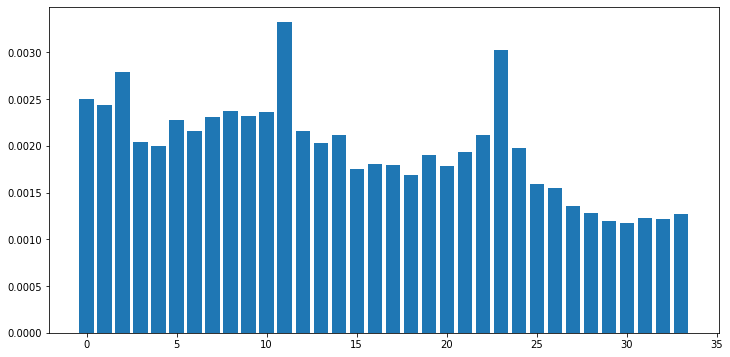

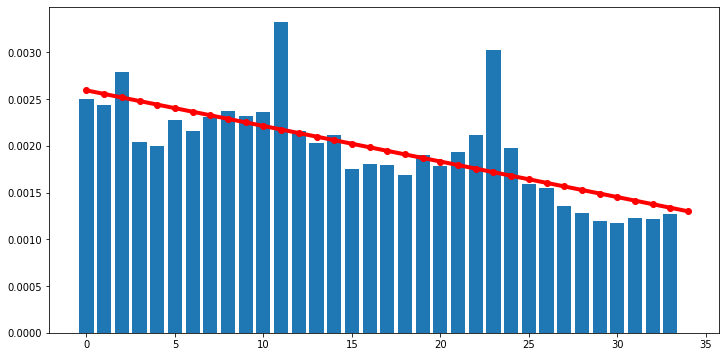

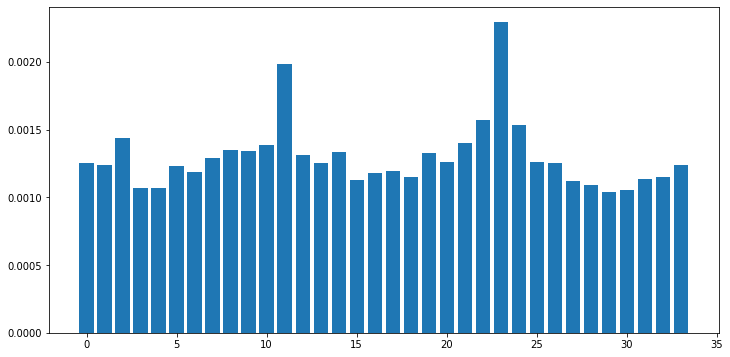

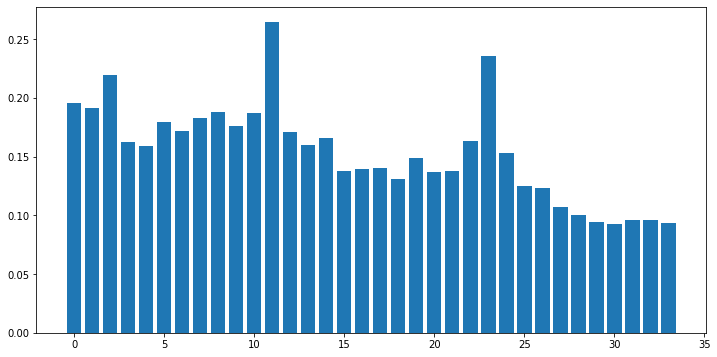

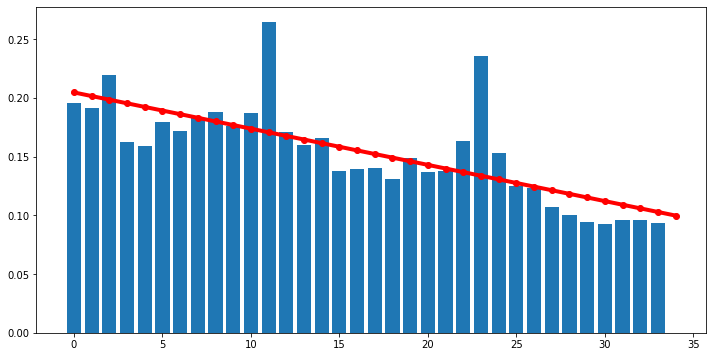

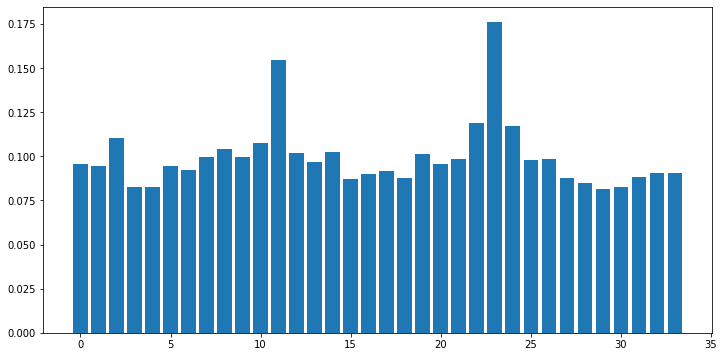

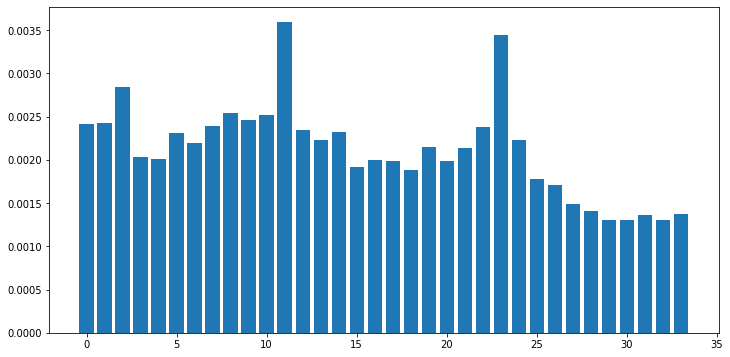

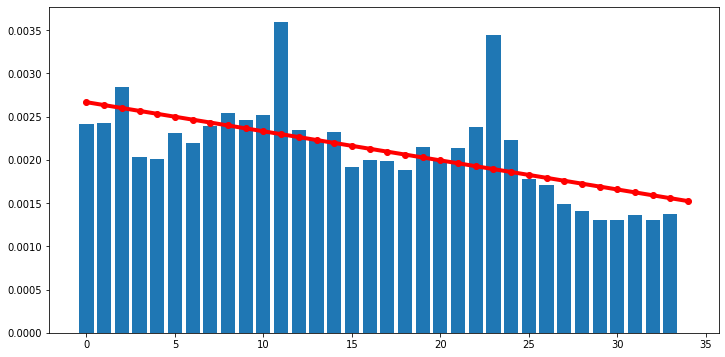

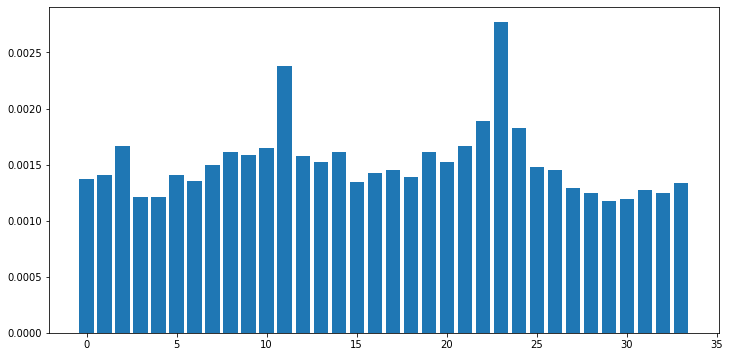

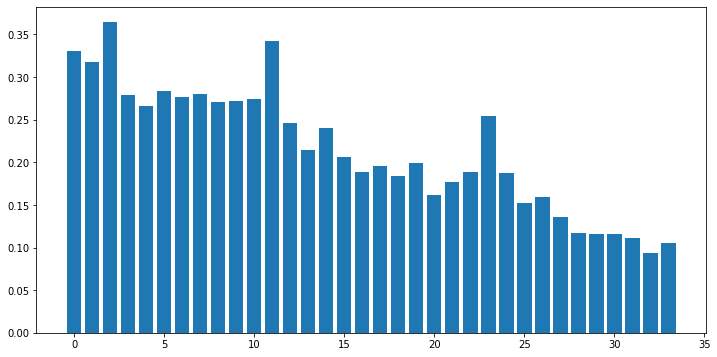

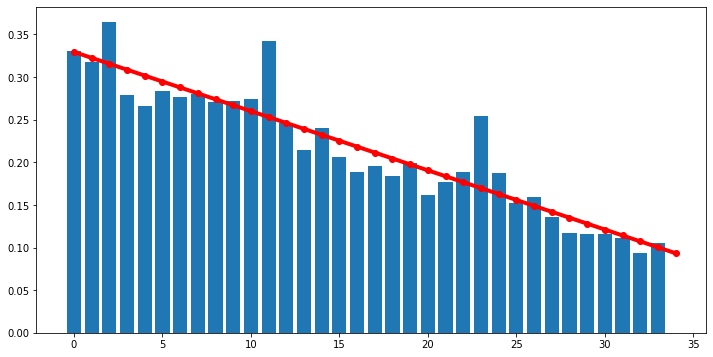

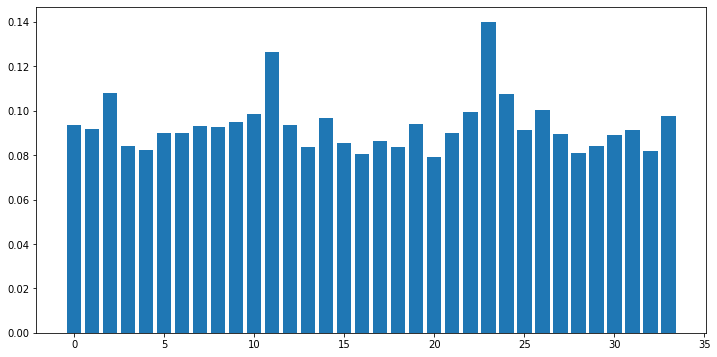

In [41]:
# I adjust transition data but not apply.
for i in range(len(features)):
    month_means = features[i].loc[:, 0:].mean()
    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,month_means)

    x = np.array(features[i].loc[:, 0:].columns)
    x = x.reshape(-1, 1)
    y = np.array(month_means)
    y = y.reshape(-1, 1)

    # Regression to predict 34 month amm (around month mean)
    mm_reg_model = LinearRegression()
    mm_reg_model.fit(x,y)

    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,month_means)

    x = np.concatenate([x, [[34]]], axis=0)
    y = mm_reg_model.predict(x)
    plt.plot(x, y, linewidth=4, color="red", marker="o")

    mm_ratio = np.array(y / y[34])
    mm_ratio = mm_ratio[:34]
    mm_ratio = mm_ratio.reshape(len(mm_ratio))

    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns, month_means / mm_ratio)


    features[i].loc[:, 0:] = features[i].loc[:, 0:] / mm_ratio

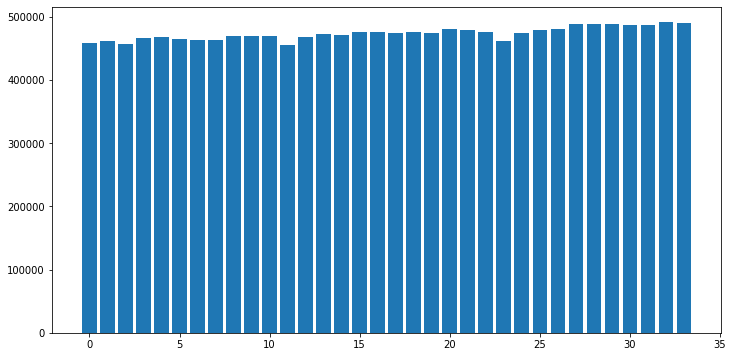

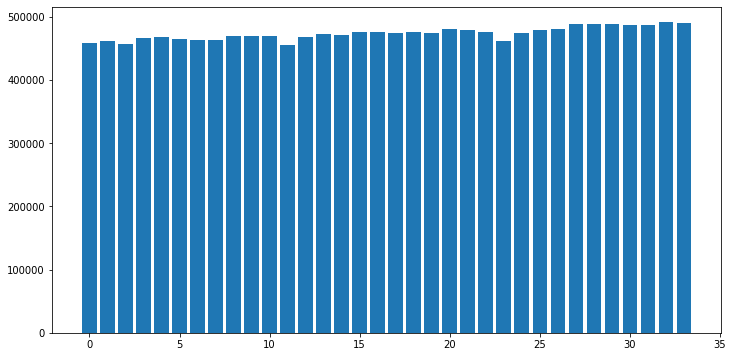

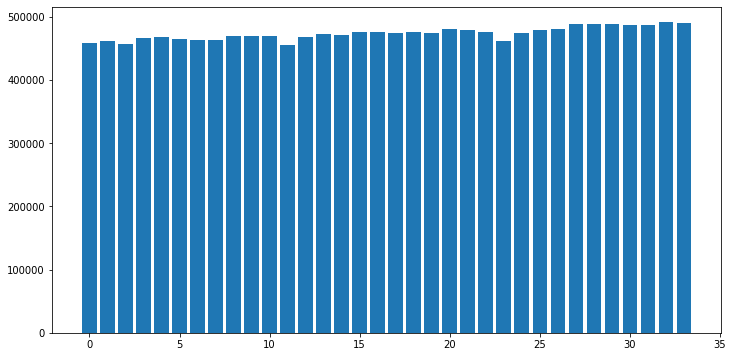

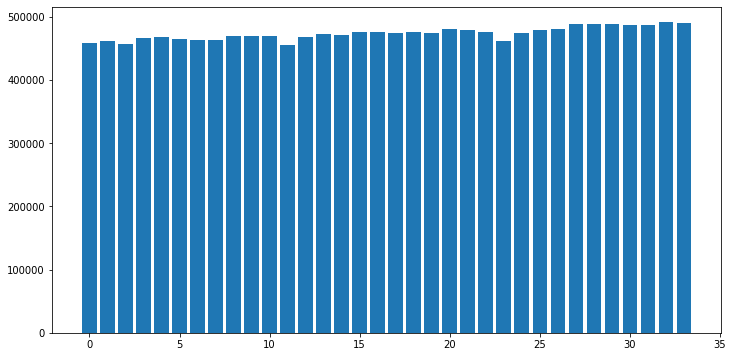

In [42]:
# I adjust transition data but not apply.
for i in range(len(features)):
    count_zero = (features[0].loc[:, 0:] == 0).sum()
    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,count_zero)

From this result, I can understand that the frequency of data wasn't changed. Only sales amount is decreasing.

<br />

# 7. Data Leakgages & Metrics Optimization
I write about that at 1.Most important ingenuity.
After leaned about Data Leakages, I want to know features of submission data. Then, from Metics Optimization lectures, I knew submitting by single value can find out mean of submission data, because it used RMSE. Thus, I estimate average is 0.3, so I define variable here.

In [43]:
pre_ave = 0.3

In [44]:
std_pre_ave = (pre_ave / transition_max)
print(std_pre_ave, pre_ave, transition_max)

0.0029702970297029703 0.3 101.0


# 8. Validation
This is time seriese dataset. Thus, I used only before 32 months data as trained data. Also, I used target is 33 month dataset as validation.

In [45]:
# Generate index
index = std_transition.index

train_index = []
val_index = []
test_index = []

train_index = index

In [46]:
# Get colum which don't has any sales inofrmation for fillna.
std_transition.loc[:20000, 0:].T.sum().sort_values()

17947     0.000000
14517     0.000000
14523     0.000000
14524     0.000000
14525     0.000000
           ...    
2240      3.284114
2637      3.506738
16572     4.021656
2238      4.147934
13770    18.228015
Length: 20001, dtype: float64

In [47]:
std_transition.loc[18252]

shop_item_id    0108398
0                   0.0
1                   0.0
2                   0.0
3                   0.0
4                   0.0
5                   0.0
6                   0.0
7                   0.0
8                   0.0
9                   0.0
10                  0.0
11                  0.0
12                  0.0
13                  0.0
14                  0.0
15                  0.0
16                  0.0
17                  0.0
18                  0.0
19                  0.0
20                  0.0
21                  0.0
22                  0.0
23                  0.0
24                  0.0
25                  0.0
26                  0.0
27                  0.0
28                  0.0
29                  0.0
30                  0.0
31                  0.0
32                  0.0
33                  0.0
Name: 18252, dtype: object

In [48]:
df_test

shop_id  item_id shop_item_id  item_category_id
0             5     5037      0505037                19
1             5     5320      0505320                55
2             5     5233      0505233                19
3             5     5232      0505232                23
4             5     5268      0505268                20
...         ...      ...          ...               ...
214195       45    18454      4518454                55
214196       45    16188      4516188                64
214197       45    15757      4515757                55
214198       45    19648      4519648                40
214199       45      969      4500969                37

[214200 rows x 4 columns]

In [49]:
sub_index = pd.DataFrame(std_transition.index, columns=['index'])
sub_index['shop_item_id'] = std_transition['shop_item_id']
sub_index = pd.merge(df_test, sub_index, on='shop_item_id',how='left')
print(sub_index.isna().sum())
sub_index = sub_index.fillna(18252)
sub_index = sub_index['index']
sub_index

shop_id             0
item_id             0
shop_item_id        0
item_category_id    0
index               0
dtype: int64


0          54094
1          54199
2          54160
3          54159
4          54177
           ...  
214195    400059
214196    399055
214197    398800
214198    400612
214199    392013
Name: index, Length: 214200, dtype: int64

In [50]:
val_index = train_index
val_index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            520905, 520906, 520907, 520908, 520909, 520910, 520911, 520912,
            520913, 520914],
           dtype='int64', length=520915)

# 9. Generate Dataset
By making class, I can generate dataset very easy.

In [51]:
class WindowGenerator():
    def __init__(self, start_month, last_target_month, input_width, train_index=train_index, val_index=val_index, test_index=test_index, sub_index=sub_index, features=features):
        self.start_month = start_month
        self.last_target_month = last_target_month
        
        # Work out the window parameters.
        self.input_width = input_width
        # It includes y value
        self.total_width = input_width + 1
        
        # Store the raw data.
        self.train_index = train_index
        self.val_index = val_index
        self.test_index = test_index
        self.sub_index = sub_index
        
        # Fixed
        self.features = features
        self.features_number = len(features)
        
        self.repeat_number = self.last_target_month - self.start_month - self.input_width
    def __repr__(self):
        return '\n'.join([
            f'Start month: {self.start_month}',
            f'Input window size: {self.input_width}',
            f'last_target_month: {self.last_target_month}',
            
            f'repeat_number: {self.repeat_number}',
            
            f'features_number: {self.features_number}',
        ])
    
    def generate_window(self, features_lists, index_i, start_point):
        one_window = []
        for window_i in range(self.input_width):
            one_features = []
            for feature_i in range(self.features_number):
                # Array start zero, so I plus 1 to start point.
                one_features.append(features_lists[feature_i][index_i][start_point + 1 + window_i])
            one_window.append(one_features)

        return one_window
    
    def generate_list(self, index):
        x_data = []
        y_data = []
        
        index_number = len(index)
        features_lists = [feature.loc[index].drop('shop_item_id', axis=1).to_numpy().tolist() for feature in features]
        
        reduce = 0
        
        # (batch, time, features)
        for index_i in range(index_number):
            for time_i in range(self.repeat_number):
                start_point = self.start_month + time_i
                one_y = features_lists[0][index_i][start_point + self.total_width]
                
#                 # Data whose target is 0 is very big, so I reduce harf. Even if after that, y mean is 0.2, so I should extract more.
#                 if self.repeat_number > 2:
#                     if one_y == 0:
#                         if np.random.rand() < 0.5:
#                             continue
                
                one_window = self.generate_window(features_lists, index_i, start_point)
                
                x_data.append(one_window)
                y_data.append(one_y)

        return x_data, y_data
    def generate_sub_x(self):
        features_lists = [feature.loc[self.sub_index].drop('shop_item_id', axis=1).to_numpy().tolist() for feature in features]
        index_number = len(self.sub_index)
        
        # start_point + self.total_width = 34
        start_point = 34 - self.total_width
        
        sub_x = []
        # (batch, time, features)
        for index_i in range(index_number):
             sub_x.append(self.generate_window(features_lists, index_i, start_point))
                
        return sub_x
    
    def make_dataset(self, index):
        x_data, y_data = self.generate_list(index)
        return tf.Dataset.from_tensor_slices((x_data, y_data))

    def train_list(self):
        return self.generate_list(self.train_index)

    def val_list(self):
        return self.generate_list(self.val_index)

    def test_list(self):
        return self.generate_list(self.test_index)
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_index)

    @property
    def val(self):
        return self.make_dataset(self.val_index)

    @property
    def test(self):
        return self.make_dataset(self.test_index)


In [52]:
input_width = 6

train_window = WindowGenerator(
    start_month = 20 - (input_width + 1),
    last_target_month = 32,
    input_width = input_width,
)
train_window

Start month: 13
Input window size: 6
last_target_month: 32
repeat_number: 13
features_number: 4

In [53]:
val_window = WindowGenerator(
    start_month = 33 - (input_width + 1),
    last_target_month = 33,
    input_width = input_width,
)
val_window

Start month: 26
Input window size: 6
last_target_month: 33
repeat_number: 1
features_number: 4

# 10. Adjust Dataset
After generating dataset from above class by separate train and val by 10. Vlidation method, I eliminate some data less than estimated 34 months average.

In [54]:
%%time
x_train, y_train = train_window.train_list()

CPU times: user 1min 55s, sys: 6.46 s, total: 2min 1s
Wall time: 2min 1s


In [55]:
%%time
x_val, y_val = val_window.val_list()

CPU times: user 20.6 s, sys: 1.94 s, total: 22.6 s
Wall time: 22.5 s


In [56]:
adj_x_train = np.array(x_train)
adj_y_train = np.array(y_train)
adj_y_train = adj_y_train.clip(0, 20.0 / transition_max)
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())

0.0012340136451739856 0.007467436725592359 0.19801980198019803


(array([6.262283e+06, 1.735550e+05, 2.348520e+05, 5.494600e+04,
        2.264100e+04, 1.027700e+04, 5.020000e+03, 2.839000e+03,
        1.647000e+03, 3.835000e+03]),
 array([0.        , 0.04449942, 0.08899883, 0.13349825, 0.17799766,
        0.22249708, 0.2669965 , 0.31149591, 0.35599533, 0.40049474,
        0.44499416]),
 <BarContainer object of 10 artists>)

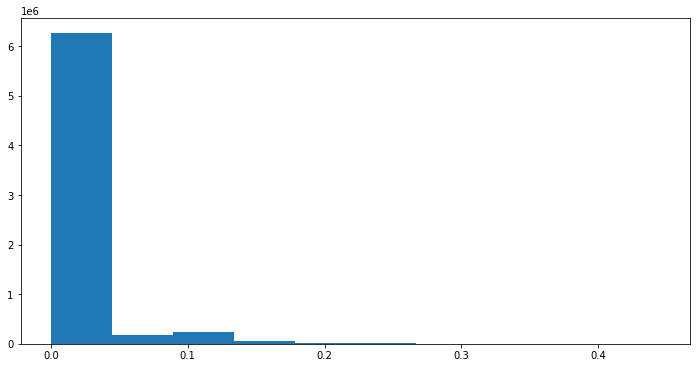

In [57]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_train))

In [58]:
# One time delete 0.01%
over_index = np.where(adj_y_train < std_pre_ave)[0]
print(over_index)
print(len(adj_y_train), len(over_index))
drop_rate = 0.035
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005

[      0       3       6 ... 6771892 6771893 6771894]
6771895 6262283
219179


In [59]:
%%time
for i in range(100):
    over_index = np.where(adj_y_train < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_train = np.delete(adj_x_train, drop_index, 0)
    adj_y_train = np.delete(adj_y_train, drop_index)
    if adj_y_train.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())

Stop i:43
0.002934848331720905 0.011297266965073117 0.19801980198019803
CPU times: user 16.9 s, sys: 10.8 s, total: 27.7 s
Wall time: 27.8 s


In [60]:
adj_x_val = np.array(x_val)
adj_y_val = np.array(y_val)
adj_y_val = adj_y_val.clip(0, 20.0 / transition_max)
print(adj_y_val.mean(), adj_y_val.std(), adj_y_val.max())

0.0011415958824261018 0.007560757166340346 0.19801980198019803


(array([4.89394e+05, 0.00000e+00, 2.13690e+04, 7.00200e+03, 1.54700e+03,
        5.66000e+02, 4.00000e+02, 1.84000e+02, 1.30000e+02, 3.23000e+02]),
 array([0.        , 0.04449942, 0.08899883, 0.13349825, 0.17799766,
        0.22249708, 0.2669965 , 0.31149591, 0.35599533, 0.40049474,
        0.44499416]),
 <BarContainer object of 10 artists>)

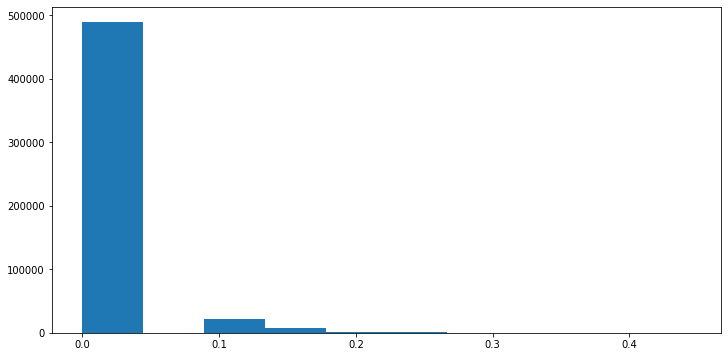

In [61]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_val))

In [62]:
# One time delete 0.01%
over_index = np.where(adj_y_val < std_pre_ave)[0]
print(over_index)
print(len(adj_y_val), len(over_index))
drop_rate = 0.02
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005

[     0      4      5 ... 520912 520913 520914]
520915 489394
9787


In [63]:
%%time
for i in range(100):
    over_index = np.where(adj_y_val < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_val = np.delete(adj_x_val, drop_index, 0)
    adj_y_val = np.delete(adj_y_val, drop_index)
    if adj_y_val.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_val.mean(), adj_y_val.std(), adj_y_val.max())

Stop i:99
0.0018176868171353253 0.009475820007168286 0.19801980198019803
CPU times: user 2.46 s, sys: 1.42 s, total: 3.88 s
Wall time: 3.88 s


(array([2.95639e+05, 0.00000e+00, 2.13690e+04, 7.00200e+03, 1.54700e+03,
        5.66000e+02, 4.00000e+02, 1.84000e+02, 1.30000e+02, 3.23000e+02]),
 array([0.        , 0.04449942, 0.08899883, 0.13349825, 0.17799766,
        0.22249708, 0.2669965 , 0.31149591, 0.35599533, 0.40049474,
        0.44499416]),
 <BarContainer object of 10 artists>)

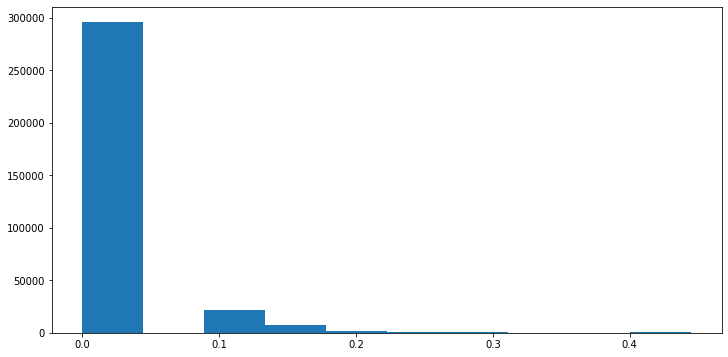

In [64]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_val))

In [65]:
del x_train, y_train, x_val, y_val

In [66]:
def flatten_x(x):
    flat_row = []
    for one_row in x:
        temp_flat_row = []
        for feature_set in one_row:
            for one_feature in feature_set:
                temp_flat_row.append(one_feature)
        flat_row.append(temp_flat_row)
        
    return flat_row

In [67]:
adj_x_train = flatten_x(adj_x_train)
adj_x_val = flatten_x(adj_x_val)

# 11. Ensemble
I did hyperparameter tuning. I ensemble three types of gradient boost models.

In [68]:
models = []

In [69]:
lgb_train = lgb.Dataset(adj_x_train, adj_y_train, free_raw_data=False)
lgb_val = lgb.Dataset(adj_x_val, adj_y_val, reference=lgb_train, free_raw_data=False)


lgbm_params = {
    'objective': 'mse',
    'metric': 'rmse',
    "num_leaves": 500,
    'is_unbalance':True,
    'boosting':'gbdt',
    "learning_rate": 0.01,
    'num_boost_round': 10000,
    'early_stopping_rounds':200
}
model = lgb.train(lgbm_params,
                  lgb_train,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_val],
                  early_stopping_rounds=20,
                  verbose_eval=100)

model.save_model(f'./lgb_model')
models.append(model)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.834066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6110
[LightGBM] [Info] Number of data points in the train set: 2847374, number of used features: 24
[LightGBM] [Info] Start training from score 0.002935
Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.00859832	valid's rmse: 0.0080848
[200]	train's rmse: 0.00792217	valid's rmse: 0.00789071
[300]	train's rmse: 0.0076444	valid's rmse: 0.00788077
[400]	train's rmse: 0.0074573	valid's rmse: 0.00788159
Early stopping, best iteration is:
[274]	train's rmse: 0.00770088	valid's rmse: 0.00787844


In [70]:
model = catboost.CatBoostRegressor(
    iterations=700,
    learning_rate=0.02,
    depth=12,
    eval_metric='RMSE',
    random_seed = 23,
    bagging_temperature = 0.2,
    od_type='Iter',
    metric_period = 75,
    od_wait=100
)

model.fit(
    adj_x_train,
    adj_y_train, 
    eval_set=(adj_x_val,adj_y_val),
)

model.save_model(f'./cat_model')
models.append(model)

0:	learn: 0.0112077	test: 0.0094823	best: 0.0094823 (0)	total: 1.14s	remaining: 13m 19s
75:	learn: 0.0086686	test: 0.0079950	best: 0.0079950 (75)	total: 1m 19s	remaining: 10m 51s
150:	learn: 0.0083521	test: 0.0079167	best: 0.0079164 (149)	total: 2m 37s	remaining: 9m 33s
225:	learn: 0.0082265	test: 0.0079188	best: 0.0079147 (174)	total: 3m 57s	remaining: 8m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.007914711634
bestIteration = 174

Shrink model to first 175 iterations.


In [71]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
)
model.fit(
    adj_x_train,
    adj_y_train, 
    eval_metric="rmse", 
    eval_set=[(adj_x_val, adj_y_val)], 
    verbose=True, 
    early_stopping_rounds = 10
)
model.save_model(f'./xgb_model')
models.append(model)

[0]	validation_0-rmse:0.34900
[1]	validation_0-rmse:0.24442
[2]	validation_0-rmse:0.17126
[3]	validation_0-rmse:0.12011
[4]	validation_0-rmse:0.08439
[5]	validation_0-rmse:0.05942
[6]	validation_0-rmse:0.04205
[7]	validation_0-rmse:0.03005
[8]	validation_0-rmse:0.02186
[9]	validation_0-rmse:0.01638
[10]	validation_0-rmse:0.01285
[11]	validation_0-rmse:0.01069
[12]	validation_0-rmse:0.00942
[13]	validation_0-rmse:0.00872
[14]	validation_0-rmse:0.00835
[15]	validation_0-rmse:0.00815
[16]	validation_0-rmse:0.00804
[17]	validation_0-rmse:0.00799
[18]	validation_0-rmse:0.00795
[19]	validation_0-rmse:0.00794
[20]	validation_0-rmse:0.00793
[21]	validation_0-rmse:0.00792
[22]	validation_0-rmse:0.00792
[23]	validation_0-rmse:0.00793
[24]	validation_0-rmse:0.00793
[25]	validation_0-rmse:0.00793
[26]	validation_0-rmse:0.00793
[27]	validation_0-rmse:0.00793
[28]	validation_0-rmse:0.00793
[29]	validation_0-rmse:0.00793
[30]	validation_0-rmse:0.00793


In [72]:
# Gradient boosting models
sub_x = train_window.generate_sub_x()
sub_x = flatten_x(sub_x)

preds = np.zeros(len(sub_x))
for model in models:
    preds = preds + model.predict(sub_x)
preds = preds / len(models)

In [73]:
# preds = model.predict(sub_x)
preds = preds * transition_max
preds = preds.clip(0.0, 20.0)

In [74]:
print(preds.mean(), preds.std(), preds.max())

0.3466833274744011 0.6905306326442903 19.95655078160176


(array([1.66523e+05, 2.82620e+04, 1.02420e+04, 3.71600e+03, 1.80800e+03,
        1.04000e+03, 6.17000e+02, 4.33000e+02, 3.22000e+02, 2.34000e+02,
        1.40000e+02, 1.48000e+02, 8.80000e+01, 8.30000e+01, 6.70000e+01,
        4.80000e+01, 4.20000e+01, 2.80000e+01, 4.30000e+01, 2.90000e+01,
        3.60000e+01, 1.90000e+01, 2.30000e+01, 1.70000e+01, 8.00000e+00,
        1.50000e+01, 1.00000e+01, 9.00000e+00, 1.00000e+01, 1.00000e+01,
        9.00000e+00, 4.00000e+00, 1.10000e+01, 6.00000e+00, 1.00000e+01,
        5.00000e+00, 2.00000e+00, 6.00000e+00, 8.00000e+00, 6.00000e+00,
        4.00000e+00, 4.00000e+00, 1.00000e+01, 4.00000e+00, 3.00000e+00,
        6.00000e+00, 8.00000e+00, 1.30000e+01, 9.00000e+00, 2.00000e+00]),
 array([1.71694424e-02, 4.15957069e-01, 8.14744696e-01, 1.21353232e+00,
        1.61231995e+00, 2.01110758e+00, 2.40989520e+00, 2.80868283e+00,
        3.20747046e+00, 3.60625808e+00, 4.00504571e+00, 4.40383334e+00,
        4.80262096e+00, 5.20140859e+00, 5.60019622e+

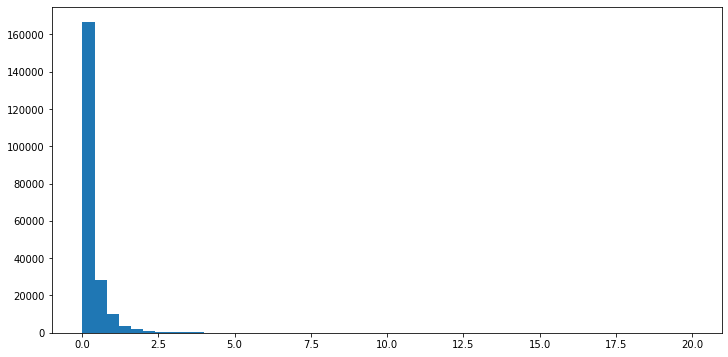

In [75]:
plt.figure(figsize=(12,6))
plt.hist(preds,bins=50)

(array([ 1586., 19719., 28644., 21113., 13555., 10897.,  8438.,  7789.,
         6885.,  6610.,  5991.,  5355.,  4578.,  4579.,  3993.,  3756.,
         3465.,  3080.,  2948.,  2758.,  2563.,  2230.,  2102.,  2020.,
         1949.,  1819.,  1630.,  1518.,  1475.,  1349.,  1239.,  1135.,
         1085.,  1044.,   978.,   969.,   994.,   873.,   861.,   766.,
          790.,   770.,   744.,   661.,   586.,   660.,   578.,   572.,
          521.,   562.]),
 array([0.01716944, 0.036826  , 0.05648256, 0.07613912, 0.09579568,
        0.11545224, 0.1351088 , 0.15476536, 0.17442192, 0.19407848,
        0.21373504, 0.2333916 , 0.25304816, 0.27270472, 0.29236128,
        0.31201784, 0.3316744 , 0.35133096, 0.37098752, 0.39064408,
        0.41030064, 0.4299572 , 0.44961376, 0.46927032, 0.48892688,
        0.50858344, 0.52824   , 0.54789656, 0.56755312, 0.58720968,
        0.60686624, 0.6265228 , 0.64617936, 0.66583591, 0.68549247,
        0.70514903, 0.72480559, 0.74446215, 0.76411871, 0.78377527

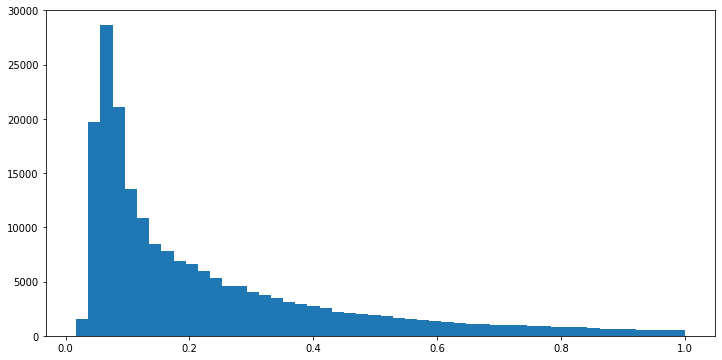

In [76]:
plt.figure(figsize=(12,6))
plt.hist(preds[(preds>0.0) & (preds<1.0)],bins=50)

In [77]:
sample['item_cnt_month'] = preds
sample.to_csv('submission.csv', index=False)

In [78]:
sample.head(50)

ID  item_cnt_month
0    0        0.913805
1    1        0.096114
2    2        1.243612
3    3        0.559652
4    4        0.089954
5    5        0.789711
6    6        1.062045
7    7        0.290885
8    8        1.102408
9    9        0.690713
10  10        2.471303
11  11        0.374038
12  12        0.212167
13  13        0.837498
14  14        1.510888
15  15        2.791308
16  16        0.195507
17  17        0.305263
18  18        1.333684
19  19        0.332781
20  20        0.831535
21  21        0.420569
22  22        1.986787
23  23        0.803307
24  24        1.494042
25  25        1.024687
26  26        0.578532
27  27        0.958146
28  28        1.256214
29  29        4.679816
30  30        1.218086
31  31        0.377229
32  32        1.106450
33  33        1.154864
34  34        0.074383
35  35        0.086078
36  36        0.107072
37  37        1.251892
38  38        0.310274
39  39        0.246668
40  40        0.921955
41  41        1.510704
42  42        3.775485
43  43        3.532397
44  44        1.204882
45  45        0.147072
46  46        1.281933
47  47        0.603138
48  48        0.828257
49  49        1.095565